# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data](#Data)
* [Feature extaction](#Extract-features)
* [Setup](#Setup)
* [Explore models](#Explore-models)
  * [Multilayer perceptron (keras)](#Multilayer-perceptron-(keras))
  * [Test harness](#Test-harness)
  * [Classifiers from sklearn](#Classifiers-from-sklearn)
    * [sklearn Models](#sklearn-Models)
    * [sklearn results collection](#sklearn-results-collection)
  * [Other boosting ensembles](#Other-boosting-ensembles)
    * [Non-sklearn Models](#Non-sklearn-Models)
    * [Non-sklearn results collection](#Non-sklearn-results-collection)
  * [Stacked classifier](#Stacked-classifier)
    * [Feature importance](#Feature-importance)
* [Results](#Results)
* [Discussion](#Discussion)

## Intro

This notebook uses FRILL to generate embeddings for the ragged samples of short duration. The resultant embeddings are passed to a variety of classifiers including a stacked ensemble. The ternary, single-valence binary, and ternary one-vs-rest classification cases are considered. Results are visualized and discussed.

### FRILL

Here are two abstracts to introduce the FRILL embedding:

>> [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
>>>> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.
>>
>> [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
>>>> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers now available.

## Imports and configuration

In [1]:
# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from time import time
from tqdm.notebook import tqdm
import swifter

# Python < 3.9 type hints
from typing import Callable, List, Sequence, Tuple

# metrics
from sklearn.metrics import accuracy_score

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# other boosting classifiers
from lightgbm import LGBMClassifier

# from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# keras & tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1_l2
import tensorflow as tf2
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# hide warnings
import warnings

warnings.filterwarnings("ignore")

time: 4.21 s


In [4]:
# Location of ragged data (as pickle)
PICKLED_DF_FOLDER = "../3.0-mic-pad_data_short"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

# The preprocessed data from the Unified Multilingual Dataset of Emotional Human utterances
WAV_DIRECTORY = (
    "../../unified_multilingual_dataset_of_emotional_human_utterances/data/preprocessed"
)

time: 999 µs


## Data

In [5]:
short_df = pd.read_pickle(f"{PICKLED_DF_FOLDER}/short_ragged.pkl")
short_df.head(1)

,file,duration,source,speaker_id,speaker_gender,emo,valence,lang1,lang2,neg,neu,pos,length,ragged
id,,,,,,,,,,,,,,
01788,01788+BAUM1+BAUM1.s028+f+hap+1+tur+tr-tr.wav,0.387,BAUM1,BAUM1.s028,f,hap,1,tur,tr-tr,0,0,1,short,"[-6.1035156e-05, -6.1035156e-05, 0.0, -3.05175..."


time: 49 ms


In [6]:
df = short_df[["speaker_id", "valence", "neg", "neu", "pos", "ragged"]]
del short_df
_ = gc_collect()

time: 140 ms


## Feature extraction

In [7]:
tf.enable_v2_behavior()
module = hub.load("https://tfhub.dev/google/nonsemantic-speech-benchmark/frill/1")

time: 36.8 s


In [8]:
df["frill"] = df.ragged.swifter.apply(
    lambda _: module(np.expand_dims(np.array(_, dtype=np.float32), axis=0))[
        "embedding"
    ][0].numpy()
)

Pandas Apply:   0%|          | 0/480 [00:00<?, ?it/s]

time: 1min 47s


## Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of three-fold cross validation such that the results may be easily cast to a `pandas` dataframe.

In [9]:
# classification scenarios
all_cases = {"ternary", "negative", "neutral", "positive", "ternary_ovr"}
metrics = {"avg_cv_accuracy", "vs_dummy", "avg_cv_fit_time", "avg_cv_predict_time"}

# to be cast to pd.DataFrame
results = {case: {key: [] for key in {"model_name", *metrics}} for case in all_cases}

time: 1 ms


In [10]:
AvgScores = namedtuple(
    "AvgScores", "avg_fit_time avg_predict_time avg_accuracy avg_dummy"
)


def store_result(case: str, model_name: str, avg_scores: AvgScores) -> None:
    "Appends a model's score and fit/predict times to the results."
    result = results[case]
    for attribute, value in {
        ("model_name", model_name),
        ("avg_cv_accuracy", (_ := avg_scores.avg_accuracy)),
        ("vs_dummy", _ - avg_scores.avg_dummy),
        ("avg_cv_fit_time", avg_scores.avg_fit_time),
        ("avg_cv_predict_time", avg_scores.avg_predict_time),
    }:
        result[attribute].append(value)

time: 2 ms


### Multilayer perceptron (keras)

To use `keras`, the data must be formatted a little differently, so we will process the `keras` network outside the main loop through the other models and cases.

We will use a simple fully connected network to get a baseline. To determine the number of neurons in the hidden layer, we use the rule of thumb, *sqrt(n * m)*, where n is the number of input neurons and m is the number of output neurons.

After a little trial and error (not shown), I noticed that the network was overfitting rapidly, so I added an ElasticNet kernel regularizer. As a result, loss and accuracy plateaued in just a few epochs both in training and validation. Therefore, I reduced the `l1` and `l2` parameters from a default of 0.01 to 0.0001 each and validation performance improved. I didn't want to spend too much time tinkering in this phase so I left it at that.

In [11]:
# input size
n = 2048

time: 998 µs


In [12]:
def keras_MLP(print_summary: bool = False, multiclass: bool = False) -> Sequence:
    if multiclass:
        m, activation, loss = 3, "softmax", "categorical_crossentropy"
    else:
        m, activation, loss = 1, "sigmoid", "binary_crossentropy"
    model = Sequential(
        [
            Dense(
                _ := np.sqrt(n * m),
                activation="relu",
                input_dim=n,
                kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001),
            ),
            Dense(m, activation=activation),
        ]
    )
    model.compile(loss=loss, optimizer="adam", metrics="accuracy")
    if print_summary:
        model.summary()
    return model

time: 1 ms


The next cell defines a function for making cross-validation splits without speaker leakage (sampling with replacement).

In [13]:
# for formatting X_test and X_train
restack: Sequence = lambda _: tf2.convert_to_tensor(np.stack(_.to_numpy()))

# for formatting y_test and y_train
to_categorical: Sequence = lambda _: tf2.keras.utils.to_categorical(
    _, num_classes=3, dtype="float32"
)

Split = namedtuple("Split", ("X_test", "y_test", "X_train", "y_train", "dummy_test"))


def splits_for_keras(case: str, num_splits: int = 3) -> List[Split]:
    """Given a classification scenario, provide train-test splits sampled with replacement for cross validation without speaker leakage."""
    splits = []
    for i in range(num_splits):
        # criterion for split
        criterion = df.speaker_id.isin(
            pd.DataFrame(np.unique(df.speaker_id))
            .sample(frac=0.25, random_state=SEED + i)[0]
            .values
        )

        # prepare X_test and y_test
        X_test = restack((test := df.loc[criterion]).frill)
        y_test = (
            to_categorical(test.valence).argmax(axis=1)
            if (multiclass := "ternary" in case)
            else test[case[:3]]
        )

        # the dummy score is calculated from y_test
        dummy = pd.Series(y_test).value_counts().values[0] / len(y_test)
        if not multiclass and dummy < 0.5:
            dummy = 1 - dummy

        splits.append(
            Split(
                X_test=X_test,
                X_train=restack((train := df.loc[~criterion]).frill),
                y_test=y_test,
                y_train=to_categorical(train.valence)
                if multiclass
                else train[case[:3]],
                dummy_test=dummy,
            )
        )

    return splits

time: 5 ms


The next two cells define functions for fitting, scoring, and storing the results of a `keras` classifier in each classification scenario.

In [14]:
def fit_score_store_keras_MLP_ovr() -> AvgScores:
    """Fit, score, and store the results for a keras multilayer perceptron in the one-vs-rest ensemble case."""

    cases = ("neu", "pos", "neg")  # match sort order of "0", "1", "-1"
    interim_results = {
        case: dict.fromkeys(("cv_fit_times", "cv_predict_times"), []) for case in cases
    }
    predicted_probabilities = {fold: {k: None for k in cases} for fold in range(3)}

    for case in ("neutral", "positive", "negative"):
        fit_times, predict_times = [], []
        fold = 0
        for split in splits_for_keras(case=case):
            # define model
            model = keras_MLP(multiclass=False)  # train three binary classifiers

            # fit
            reset_seeds(SEED)
            begin = time()
            model.fit(
                split.X_train,
                split.y_train,
                validation_split=0.15,
                epochs=10,
                batch_size=1,
            )
            end = time()
            fit_times.append(end - begin)

            # predict
            begin = time()
            predicted = model.predict(split.X_test)
            end = time()
            predict_times.append(end - begin)
            predicted_probabilities[fold][case[:3]] = predicted[:, 0].tolist()
            fold += 1

        result = interim_results[case[:3]]
        result["cv_fit_times"] = np.mean(fit_times)
        result["cv_predict_times"] = np.mean(predict_times)

    # aggregate predicted probabilities and argmax (ensemble) them by fold
    fold_predictions = [
        pd.DataFrame(predicted_probabilities[fold])
        .swifter.apply(lambda _: np.argmax([_]), axis=1)
        .values
        for fold in sorted(predicted_probabilities.keys())
    ]

    # score
    ternary_splits = splits_for_keras(case="ternary_ovr")
    accuracy_scores = [
        accuracy_score(y_true=true, y_pred=pred)
        for true, pred in zip(
            [split.y_test for split in ternary_splits], fold_predictions
        )
    ]

    sum_time: float = lambda fitpredict: sum(
        [interim_results[case][fitpredict] for case in cases]
    )
    store_result(
        case="ternary_ovr",
        model_name="keras_MLP",
        avg_scores=(
            keras_ovr_results := AvgScores(
                avg_fit_time=sum_time("cv_fit_times"),
                avg_predict_time=sum_time("cv_predict_times"),
                avg_accuracy=np.mean(accuracy_scores),
                avg_dummy=np.mean([split.dummy_test for split in ternary_splits]),
            )
        ),
    )
    return keras_ovr_results

time: 6 ms


In [15]:
def fit_score_store_keras_MLP(case: str) -> AvgScores:
    """Fit, score, and store the results for a keras multilayer perceptron."""

    if case == "ternary_ovr":
        return fit_score_store_keras_MLP_ovr()

    fit_times, predict_times, scores, dummies = [], [], [], []
    for split in splits_for_keras(case):
        # define model
        model = keras_MLP(multiclass=(multiclass := case == "ternary"))

        # fit
        reset_seeds(SEED)
        begin = time()
        model.fit(
            split.X_train,
            split.y_train,
            validation_split=0.15,
            epochs=10,
            batch_size=1,
        )
        end = time()
        fit_times.append(end - begin)

        # predict
        begin = time()
        predicted = model.predict(split.X_test)
        end = time()
        predict_times.append(end - begin)
        predicted = (
            predicted.argmax(axis=1)
            if multiclass
            else pd.Series(predicted[:, 0]).swifter.apply(lambda _: 1 if _ > 0.5 else 0)
        )

        # score
        scores.append(accuracy_score(y_true=split.y_test, y_pred=predicted))
        dummies.append(split.dummy_test)

    store_result(
        case=case,
        model_name="keras_MLP",
        avg_scores=(
            keras_results := AvgScores(
                *[np.mean(_) for _ in (fit_times, predict_times, scores, dummies)]
            )
        ),
    )
    return keras_results

time: 3 ms


Let's peek at the results.

In [16]:
keras_results_ternary = fit_score_store_keras_MLP(case="ternary")

Epoch 1/10
254/254 [==============================] - 2s 6ms/step - loss: 1.2174 - accuracy: 0.5118 - val_loss: 1.1347 - val_accuracy: 0.5111
Epoch 2/10
254/254 [==============================] - 1s 5ms/step - loss: 0.9346 - accuracy: 0.6339 - val_loss: 1.0015 - val_accuracy: 0.5333
Epoch 3/10
254/254 [==============================] - 1s 5ms/step - loss: 0.8476 - accuracy: 0.6969 - val_loss: 0.8862 - val_accuracy: 0.6444
Epoch 4/10
254/254 [==============================] - 1s 5ms/step - loss: 0.7415 - accuracy: 0.7559 - val_loss: 0.9003 - val_accuracy: 0.6222
Epoch 5/10
254/254 [==============================] - 1s 6ms/step - loss: 0.6860 - accuracy: 0.7913 - val_loss: 0.9416 - val_accuracy: 0.6000
Epoch 6/10
254/254 [==============================] - 1s 6ms/step - loss: 0.6323 - accuracy: 0.8425 - val_loss: 0.9782 - val_accuracy: 0.6000
Epoch 7/10
254/254 [==============================] - 2s 6ms/step - loss: 0.5764 - accuracy: 0.8465 - val_loss: 1.1194 - val_accuracy: 0.5333
Epoch 

In [17]:
keras_results_ternary

AvgScores(avg_fit_time=13.786349614461264, avg_predict_time=0.13208564122517905, avg_accuracy=0.5178443891402511, avg_dummy=0.4085367474735731)

time: 4 ms


Cross validated average accuracy was about 51.7%, which outperformed the average score of the dummy classifiers (~40.9%) by about 10.9%.

Next, we will proceed similarly for the binary and one-vs-rest ensemble cases.

In [18]:
for case in tqdm(all_cases):
    if case == "ternary":
        continue
    fit_score_store_keras_MLP(case)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
254/254 [==============================] - 2s 6ms/step - loss: 0.7200 - accuracy: 0.7205 - val_loss: 0.8812 - val_accuracy: 0.5111
Epoch 2/10
254/254 [==============================] - 1s 5ms/step - loss: 0.5627 - accuracy: 0.7480 - val_loss: 0.7176 - val_accuracy: 0.6000
Epoch 3/10
254/254 [==============================] - 1s 5ms/step - loss: 0.5192 - accuracy: 0.7677 - val_loss: 0.6613 - val_accuracy: 0.7111
Epoch 4/10
254/254 [==============================] - 1s 4ms/step - loss: 0.4866 - accuracy: 0.7874 - val_loss: 0.7362 - val_accuracy: 0.6000
Epoch 5/10
254/254 [==============================] - 1s 4ms/step - loss: 0.4352 - accuracy: 0.8150 - val_loss: 0.6589 - val_accuracy: 0.7333
Epoch 6/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4311 - accuracy: 0.8543 - val_loss: 0.7597 - val_accuracy: 0.6222
Epoch 7/10
254/254 [==============================] - 1s 5ms/step - loss: 0.3981 - accuracy: 0.8583 - val_loss: 0.8180 - val_accuracy: 0.6000
Epoch 

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 1/10
304/304 [==============================] - 3s 9ms/step - loss: 0.6530 - accuracy: 0.7862 - val_loss: 0.7427 - val_accuracy: 0.6852
Epoch 2/10
304/304 [==============================] - 1s 5ms/step - loss: 0.4927 - accuracy: 0.7993 - val_loss: 0.6332 - val_accuracy: 0.6667
Epoch 3/10
304/304 [==============================] - 1s 5ms/step - loss: 0.4606 - accuracy: 0.8125 - val_loss: 0.7010 - val_accuracy: 0.6111
Epoch 4/10
304/304 [==============================] - 1s 4ms/step - loss: 0.4351 - accuracy: 0.8322 - val_loss: 0.6011 - val_accuracy: 0.6852
Epoch 5/10
304/304 [==============================] - 1s 5ms/step - loss: 0.4059 - accuracy: 0.8388 - val_loss: 0.7041 - val_accuracy: 0.6296
Epoch 6/10
304/304 [==============================] - 1s 5ms/step - loss: 0.3966 - accuracy: 0.8651 - val_loss: 0.6187 - val_accuracy: 0.7037
Epoch 7/10
304/304 [==============================] - 2s 5ms/step - loss: 0.3776 - accuracy: 0.8586 - val_loss: 0.5740 - val_accuracy: 0.7593
Epoch 

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/10
294/294 [==============================] - 2s 6ms/step - loss: 0.6560 - accuracy: 0.7789 - val_loss: 0.7399 - val_accuracy: 0.6731
Epoch 2/10
294/294 [==============================] - 1s 5ms/step - loss: 0.5381 - accuracy: 0.7857 - val_loss: 0.8159 - val_accuracy: 0.6731
Epoch 3/10
294/294 [==============================] - 1s 4ms/step - loss: 0.5012 - accuracy: 0.7789 - val_loss: 0.7863 - val_accuracy: 0.6538
Epoch 4/10
294/294 [==============================] - 2s 6ms/step - loss: 0.4623 - accuracy: 0.7993 - val_loss: 0.8301 - val_accuracy: 0.6731
Epoch 5/10
294/294 [==============================] - 1s 5ms/step - loss: 0.4430 - accuracy: 0.8163 - val_loss: 0.9365 - val_accuracy: 0.6731
Epoch 6/10
294/294 [==============================] - 2s 6ms/step - loss: 0.4274 - accuracy: 0.8435 - val_loss: 1.1277 - val_accuracy: 0.6731
Epoch 7/10
294/294 [==============================] - 1s 5ms/step - loss: 0.4036 - accuracy: 0.8537 - val_loss: 0.7647 - val_accuracy: 0.7115
Epoch 

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

AvgScores(avg_fit_time=15.122881333033243, avg_predict_time=0.1074203650156657, avg_accuracy=0.6649273332639403, avg_dummy=0.7131176830276656)

Epoch 1/10
254/254 [==============================] - 2s 5ms/step - loss: 0.7072 - accuracy: 0.7126 - val_loss: 0.2194 - val_accuracy: 1.0000
Epoch 2/10
254/254 [==============================] - 1s 4ms/step - loss: 0.5327 - accuracy: 0.7874 - val_loss: 0.2019 - val_accuracy: 0.9778
Epoch 3/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4769 - accuracy: 0.8307 - val_loss: 0.1514 - val_accuracy: 1.0000
Epoch 4/10
254/254 [==============================] - 1s 4ms/step - loss: 0.4318 - accuracy: 0.8543 - val_loss: 0.1891 - val_accuracy: 0.9778
Epoch 5/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8346 - val_loss: 0.1981 - val_accuracy: 0.9778
Epoch 6/10
254/254 [==============================] - 1s 4ms/step - loss: 0.3876 - accuracy: 0.8740 - val_loss: 0.1699 - val_accuracy: 0.9778
Epoch 7/10
254/254 [==============================] - 1s 5ms/step - loss: 0.3638 - accuracy: 0.8898 - val_loss: 0.2196 - val_accuracy: 0.9778
Epoch 

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

AvgScores(avg_fit_time=41.49389974276225, avg_predict_time=0.2798042297363281, avg_accuracy=0.50451595838397, avg_dummy=0.4085367474735731)

Epoch 1/10
254/254 [==============================] - 2s 6ms/step - loss: 0.7379 - accuracy: 0.6929 - val_loss: 0.9377 - val_accuracy: 0.4667
Epoch 2/10
254/254 [==============================] - 1s 5ms/step - loss: 0.5617 - accuracy: 0.8071 - val_loss: 0.9260 - val_accuracy: 0.4444
Epoch 3/10
254/254 [==============================] - 1s 5ms/step - loss: 0.5070 - accuracy: 0.8386 - val_loss: 0.9519 - val_accuracy: 0.4444
Epoch 4/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4642 - accuracy: 0.8268 - val_loss: 0.8400 - val_accuracy: 0.6000
Epoch 5/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4295 - accuracy: 0.8661 - val_loss: 1.0879 - val_accuracy: 0.4222
Epoch 6/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4133 - accuracy: 0.8976 - val_loss: 0.9904 - val_accuracy: 0.4889
Epoch 7/10
254/254 [==============================] - 1s 5ms/step - loss: 0.3725 - accuracy: 0.9094 - val_loss: 1.0572 - val_accuracy: 0.4444
Epoch 

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 1/10
304/304 [==============================] - 2s 5ms/step - loss: 0.7379 - accuracy: 0.7237 - val_loss: 1.0839 - val_accuracy: 0.3889
Epoch 2/10
304/304 [==============================] - 1s 5ms/step - loss: 0.5808 - accuracy: 0.7862 - val_loss: 0.8215 - val_accuracy: 0.5926
Epoch 3/10
304/304 [==============================] - 1s 5ms/step - loss: 0.5103 - accuracy: 0.8158 - val_loss: 0.7258 - val_accuracy: 0.6296
Epoch 4/10
304/304 [==============================] - 1s 5ms/step - loss: 0.4716 - accuracy: 0.8421 - val_loss: 0.9224 - val_accuracy: 0.5926
Epoch 5/10
304/304 [==============================] - 1s 4ms/step - loss: 0.4490 - accuracy: 0.8553 - val_loss: 0.7878 - val_accuracy: 0.6111
Epoch 6/10
304/304 [==============================] - 1s 5ms/step - loss: 0.3938 - accuracy: 0.9046 - val_loss: 0.9395 - val_accuracy: 0.5370
Epoch 7/10
304/304 [==============================] - 1s 5ms/step - loss: 0.4019 - accuracy: 0.8980 - val_loss: 0.9441 - val_accuracy: 0.5185
Epoch 

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/10
294/294 [==============================] - 2s 5ms/step - loss: 0.7322 - accuracy: 0.7007 - val_loss: 0.9827 - val_accuracy: 0.3462
Epoch 2/10
294/294 [==============================] - 1s 5ms/step - loss: 0.5946 - accuracy: 0.7823 - val_loss: 0.7735 - val_accuracy: 0.6346
Epoch 3/10
294/294 [==============================] - 1s 5ms/step - loss: 0.5312 - accuracy: 0.7993 - val_loss: 0.7599 - val_accuracy: 0.5962
Epoch 4/10
294/294 [==============================] - 1s 5ms/step - loss: 0.4886 - accuracy: 0.8333 - val_loss: 0.7948 - val_accuracy: 0.6731
Epoch 5/10
294/294 [==============================] - 1s 5ms/step - loss: 0.4712 - accuracy: 0.8401 - val_loss: 0.8419 - val_accuracy: 0.5962
Epoch 6/10
294/294 [==============================] - 2s 5ms/step - loss: 0.4736 - accuracy: 0.8435 - val_loss: 0.8354 - val_accuracy: 0.5962
Epoch 7/10
294/294 [==============================] - 1s 5ms/step - loss: 0.4252 - accuracy: 0.8810 - val_loss: 0.8787 - val_accuracy: 0.6346
Epoch 

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

AvgScores(avg_fit_time=14.495652278264364, avg_predict_time=0.07811649640401204, avg_accuracy=0.7041574123765738, avg_dummy=0.6556180694210317)

Epoch 1/10
254/254 [==============================] - 2s 5ms/step - loss: 0.7072 - accuracy: 0.7126 - val_loss: 0.2194 - val_accuracy: 1.0000
Epoch 2/10
254/254 [==============================] - 1s 5ms/step - loss: 0.5327 - accuracy: 0.7874 - val_loss: 0.2019 - val_accuracy: 0.9778
Epoch 3/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4769 - accuracy: 0.8307 - val_loss: 0.1514 - val_accuracy: 1.0000
Epoch 4/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4318 - accuracy: 0.8543 - val_loss: 0.1891 - val_accuracy: 0.9778
Epoch 5/10
254/254 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8346 - val_loss: 0.1981 - val_accuracy: 0.9778
Epoch 6/10
254/254 [==============================] - 2s 9ms/step - loss: 0.3876 - accuracy: 0.8740 - val_loss: 0.1699 - val_accuracy: 0.9778
Epoch 7/10
254/254 [==============================] - 2s 7ms/step - loss: 0.3638 - accuracy: 0.8898 - val_loss: 0.2196 - val_accuracy: 0.9778
Epoch 

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Epoch 1/10
304/304 [==============================] - 2s 6ms/step - loss: 0.7356 - accuracy: 0.6546 - val_loss: 0.2576 - val_accuracy: 1.0000
Epoch 2/10
304/304 [==============================] - 1s 5ms/step - loss: 0.5525 - accuracy: 0.7697 - val_loss: 0.1829 - val_accuracy: 1.0000
Epoch 3/10
304/304 [==============================] - 2s 5ms/step - loss: 0.5037 - accuracy: 0.7730 - val_loss: 0.2342 - val_accuracy: 0.9815
Epoch 4/10
304/304 [==============================] - 1s 5ms/step - loss: 0.4768 - accuracy: 0.8224 - val_loss: 0.2188 - val_accuracy: 0.9815
Epoch 5/10
304/304 [==============================] - 1s 5ms/step - loss: 0.4405 - accuracy: 0.8421 - val_loss: 0.1890 - val_accuracy: 1.0000
Epoch 6/10
304/304 [==============================] - 2s 5ms/step - loss: 0.3960 - accuracy: 0.9013 - val_loss: 0.2093 - val_accuracy: 0.9815
Epoch 7/10
304/304 [==============================] - 1s 5ms/step - loss: 0.3869 - accuracy: 0.8849 - val_loss: 0.1755 - val_accuracy: 1.0000
Epoch 

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/10
294/294 [==============================] - 2s 5ms/step - loss: 0.7965 - accuracy: 0.6156 - val_loss: 0.5122 - val_accuracy: 0.9423
Epoch 2/10
294/294 [==============================] - 1s 4ms/step - loss: 0.6546 - accuracy: 0.7041 - val_loss: 0.3411 - val_accuracy: 0.9615
Epoch 3/10
294/294 [==============================] - 1s 4ms/step - loss: 0.5901 - accuracy: 0.7415 - val_loss: 0.2586 - val_accuracy: 0.9808
Epoch 4/10
294/294 [==============================] - 1s 4ms/step - loss: 0.5445 - accuracy: 0.7619 - val_loss: 0.2808 - val_accuracy: 0.9615
Epoch 5/10
294/294 [==============================] - 1s 4ms/step - loss: 0.5227 - accuracy: 0.7823 - val_loss: 0.2839 - val_accuracy: 0.9615
Epoch 6/10
294/294 [==============================] - 1s 5ms/step - loss: 0.5006 - accuracy: 0.8265 - val_loss: 0.2847 - val_accuracy: 0.9423
Epoch 7/10
294/294 [==============================] - 1s 5ms/step - loss: 0.4531 - accuracy: 0.8639 - val_loss: 0.2034 - val_accuracy: 0.9615
Epoch 

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

AvgScores(avg_fit_time=14.815510829289755, avg_predict_time=0.09375850359598796, avg_accuracy=0.6851083320829058, avg_dummy=0.6312642475513025)

time: 4min 20s


Let's peek at the results.

In [19]:
results

{'positive': {'avg_cv_predict_time': [0.1074203650156657],
  'avg_cv_fit_time': [15.122881333033243],
  'model_name': ['keras_MLP'],
  'vs_dummy': [-0.04819034976372538],
  'avg_cv_accuracy': [0.6649273332639403]},
 'ternary_ovr': {'avg_cv_predict_time': [0.2798042297363281],
  'avg_cv_fit_time': [41.49389974276225],
  'model_name': ['keras_MLP'],
  'vs_dummy': [0.0959792109103969],
  'avg_cv_accuracy': [0.50451595838397]},
 'negative': {'avg_cv_predict_time': [0.07811649640401204],
  'avg_cv_fit_time': [14.495652278264364],
  'model_name': ['keras_MLP'],
  'vs_dummy': [0.048539342955542075],
  'avg_cv_accuracy': [0.7041574123765738]},
 'neutral': {'avg_cv_predict_time': [0.09375850359598796],
  'avg_cv_fit_time': [14.815510829289755],
  'model_name': ['keras_MLP'],
  'vs_dummy': [0.053844084531603276],
  'avg_cv_accuracy': [0.6851083320829058]},
 'ternary': {'avg_cv_predict_time': [0.13208564122517905],
  'avg_cv_fit_time': [13.786349614461264],
  'model_name': ['keras_MLP'],
  'vs_du

time: 0 ns


### Test harness

This section defines some helper functions for trying out each model.

The next cell defines a function for making 3-fold train-validation splits without speaker leakage. Speakers are randomly sampled in a 1:3::test:train ratio with replacement for each fold.

In [20]:
# copied from above for reference
# Split = namedtuple("Split", ("X_test", "y_test", "X_train", "y_train" "dummy_test"))
def make_splits(case: str, num_splits: int = 3) -> List[Split]:
    """Given a classification scenario, provide train-test splits sampled with replacement for cross validation without speaker leakage."""
    splits = []
    for i in range(num_splits):
        # criterion for split
        criterion = df.speaker_id.isin(
            pd.DataFrame(np.unique(df.speaker_id))
            .sample(frac=0.25, random_state=SEED + i)[0]
            .values
        )

        # prepare X_test and y_test
        X_test = np.stack((test := df.loc[criterion]).frill)
        y_test = (
            np.int8(test.valence)
            if (multiclass := "ternary" in case)
            else test[case[:3]]
        )

        # prepare X_train and y_train
        X_train = np.stack((train := df.loc[~criterion]).frill)
        y_train = np.int8(train.valence) if multiclass else train[case[:3]]

        # non-negative labels
        if case == "ternary":
            y_test += 1
            y_train += 1

        # the dummy score is calculated from y_test
        dummy = pd.Series(y_test).value_counts().values[0] / len(y_test)
        if not multiclass and dummy < 0.5:
            dummy = 1 - dummy

        splits.append(
            Split(
                X_test=X_test,
                y_test=y_test,
                X_train=X_train,
                y_train=y_train,
                dummy_test=dummy,
            )
        )
    return splits

time: 15.6 ms


The next two cells define functions for fitting and scoring a model.

In [21]:
def fit_and_score_ovr(model_base: Callable) -> AvgScores:
    """Calculates 3-fold times and scores for ternary one-vs-rest ensemble."""

    cases = ("neg", "neu", "pos")  # match sort order of -1, 0, 1
    interim_results = {
        case: dict.fromkeys(("cv_fit_times", "cv_predict_times"), []) for case in cases
    }
    predicted_probabilities = {fold: {k: None for k in cases} for fold in range(3)}

    # train three binary classifiers
    for case in ("negative", "neutral", "positive"):
        fit_times, predict_times = [], []
        fold = 0
        for split in make_splits(case=case):
            # define model
            model = model_base()

            # fit
            begin = time()
            model.fit(split.X_train, split.y_train)
            end = time()
            fit_times.append(end - begin)

            # predict
            begin = time()
            predicted = model.predict_proba(split.X_test)
            end = time()
            predict_times.append(end - begin)
            predicted_probabilities[fold][case[:3]] = predicted[:, 1]
            fold += 1

        result = interim_results[case[:3]]
        result["cv_fit_times"] = np.mean(fit_times)
        result["cv_predict_times"] = np.mean(predict_times)

    # aggregate predicted probabilities and argmax (ensemble) them by fold
    fold_predictions = [
        pd.DataFrame(predicted_probabilities[fold])
        .swifter.apply(lambda _: np.argmax([_]) - 1, axis=1)
        .values
        for fold in sorted(predicted_probabilities.keys())
    ]

    # score
    ternary_splits = make_splits(case="ternary_ovr")
    accuracy_scores = [
        accuracy_score(y_true=true, y_pred=pred)
        for true, pred in zip(
            [split.y_test for split in ternary_splits], fold_predictions
        )
    ]

    sum_time: float = lambda fitpredict: sum(
        [interim_results[case][fitpredict] for case in cases]
    )

    return AvgScores(
        avg_fit_time=sum_time("cv_fit_times"),
        avg_predict_time=sum_time("cv_predict_times"),
        avg_accuracy=np.mean(accuracy_scores),
        avg_dummy=np.mean([split.dummy_test for split in ternary_splits]),
    )

time: 15.6 ms


In [22]:
def fit_and_score(model_base: Callable, case: str) -> AvgScores:
    """Calculates 3-fold times and scores for ternary and binary cases."""

    if case == "ternary_ovr":
        return fit_and_score_ovr(model_base)

    fit_times, predict_times, scores, dummies = [], [], [], []
    for split in make_splits(case):
        # define model
        model = model_base()

        # fit
        begin = time()
        model.fit(split.X_train, split.y_train)
        end = time()
        fit_times.append(end - begin)

        # predict
        begin = time()
        predicted = model.predict(split.X_test)
        end = time()
        predict_times.append(end - begin)

        # score
        scores.append(accuracy_score(y_true=split.y_test, y_pred=predicted))
        dummies.append(split.dummy_test)

    return AvgScores(*[np.mean(_) for _ in (fit_times, predict_times, scores, dummies)])

time: 0 ns


### Classifiers from sklearn

Thanks to FRILL, we may now use the gamut of classifiers provided by `sklearn`.

### sklearn models

The next cell defines a dictionary for keeping track of `sklearn` classifiers.

For the most part, I am using the default settings of each classifier. I set the seed where I can and leverage all avilable cores where possible. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

Some of the models tested in this notebook automatically implement one-vs-rest classification for multiclass classification. In those cases, we would expect the ternary and one-vs-rest reports to be similar.

In [23]:
sklearn_models = {
    "AdaBoostClassifier": lambda: AdaBoostClassifier(random_state=SEED),
    "GaussianNB": lambda: GaussianNB(),
    "GaussianProcessClassifier": lambda: GaussianProcessClassifier(
        random_state=SEED, n_jobs=-1
    ),  # one-vs-rest for multiclass under the hood
    "LogisticRegression": lambda: LogisticRegression(random_state=SEED, n_jobs=-1),
    "MLPClassifier": lambda: MLPClassifier(random_state=SEED),
    "QuadraticDiscriminantAnalysis": lambda: QuadraticDiscriminantAnalysis(),
    "RandomForestClassifier": lambda: RandomForestClassifier(
        n_jobs=-1, random_state=SEED
    ),
    "SVC": lambda: SVC(
        random_state=SEED, probability=True
    ),  # one-vs-rest for multiclass under the hood
}

time: 0 ns


### sklearn results collection

In [24]:
for case in tqdm(all_cases):
    for model in tqdm(sklearn_models):
        store_result(
            case=case,
            model_name=model,
            avg_scores=fit_and_score(sklearn_models[model], case),
        )

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

time: 3min 41s


## Other boosting ensembles

We may evaluate boosting ensembles outside of `sklearn` with the same test harness since they implement the ubiquitous `.fit` and `.predict` methods of the `sklearn` application programming interface (API). The selected classifiers implement the `.predict_proba` method as well, enabling ternary one-vs-rest classification.

Two boosting ensemble classifiers outside of `sklearn` were chosen: Light Gradient Boosting Machine (LightGBM), and Extreme Gradient Boosting (XGBoost).

XGBoost requires non-negative integer labels, so we will use the `non_negative_labels` boolean parameter in the test harness. (This is a good opportunity to implement a Factory Method design pattern when I refactor.)

I had considered CatBoost as well, but its inclusion slowed down the test harness drastically in stark disproportion to the fit and predict times of the other algorithms.

### Non-sklearn models

The next cell defines a Python dictionary to track the non-sklearn models.

In [25]:
non_sklearn_models = {
    # "CatBoostClassifier": lambda: CatBoostClassifier(
    #     random_seed=SEED, verbose=100, thread_count=-1
    # ),
    "LGBMClassifier": lambda: LGBMClassifier(
        boosting_type="rf",
        random_state=SEED,
        n_jobs=-1,
        subsample=0.75,
        subsample_freq=1,
    ),
    "XGBClassifier": lambda: XGBClassifier(
        eval_metric="mlogloss", seed=SEED, use_label_encoder=False
    ),
}

time: 0 ns


### Non-sklearn results collection

In [26]:
for case in tqdm(all_cases):
    for model in tqdm(non_sklearn_models):
        store_result(
            case=case,
            model_name=model,
            avg_scores=fit_and_score(non_sklearn_models[model], case),
        )

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

time: 1min 12s


### Stacked classifier

Let's give a stacked ensemble a try. If it performs well, its feature importances could be illuminating.

In [27]:
models = {**sklearn_models, **non_sklearn_models}
make_StackingClassifier = lambda: StackingClassifier(
    estimators=[(model, models[model]()) for model in models],
    final_estimator=LogisticRegression(random_state=SEED, n_jobs=-1),
    n_jobs=-1,
)

time: 0 ns


In [28]:
def fit_and_score_ovr_stack() -> AvgScores:
    """Calculates 3-fold times and scores for ternary one-vs-rest ensemble from three stacked classifiers."""

    cases = ("neg", "neu", "pos")  # match sort order of -1, 0, 1
    interim_results = {
        case: dict.fromkeys(("cv_fit_times", "cv_predict_times"), []) for case in cases
    }
    predicted_probabilities = {fold: {k: None for k in cases} for fold in range(3)}

    # train three binary classifiers
    for case in ("negative", "neutral", "positive"):
        fit_times, predict_times = [], []
        fold = 0
        for split in make_splits(case=case):
            # define model
            model = make_StackingClassifier()

            # fit
            begin = time()
            model.fit(split.X_train, split.y_train)
            end = time()
            fit_times.append(end - begin)

            # predict
            begin = time()
            predicted = model.predict_proba(split.X_test)
            end = time()
            predict_times.append(end - begin)
            predicted_probabilities[fold][case[:3]] = predicted[:, 1]
            fold += 1

        result = interim_results[case[:3]]
        result["cv_fit_times"] = np.mean(fit_times)
        result["cv_predict_times"] = np.mean(predict_times)

    # aggregate predicted probabilities and argmax (ensemble) them by fold
    fold_predictions = [
        pd.DataFrame(predicted_probabilities[fold])
        .swifter.apply(lambda _: np.argmax([_]) - 1, axis=1)
        .values
        for fold in sorted(predicted_probabilities.keys())
    ]

    # score
    ternary_splits = make_splits(case="ternary_ovr")
    accuracy_scores = [
        accuracy_score(y_true=true, y_pred=pred)
        for true, pred in zip(
            [split.y_test for split in ternary_splits], fold_predictions
        )
    ]

    sum_time: float = lambda fitpredict: sum(
        [interim_results[case][fitpredict] for case in cases]
    )

    return AvgScores(
        avg_fit_time=sum_time("cv_fit_times"),
        avg_predict_time=sum_time("cv_predict_times"),
        avg_accuracy=np.mean(accuracy_scores),
        avg_dummy=np.mean([split.dummy_test for split in ternary_splits]),
    )

time: 5 ms


In [29]:
def fit_and_score_stack(case: str) -> AvgScores:
    """Calculates 3-fold times and scores for ternary and binary cases with the stacked ensemble."""

    if case == "ternary_ovr":
        return fit_and_score_ovr_stack()

    fit_times, predict_times, scores, dummies = [], [], [], []
    for split in make_splits(case):
        # define model
        model = make_StackingClassifier()

        # fit
        begin = time()
        model.fit(split.X_train, split.y_train)
        end = time()
        fit_times.append(end - begin)

        # predict
        begin = time()
        predicted = model.predict(split.X_test)
        end = time()
        predict_times.append(end - begin)

        # score
        scores.append(accuracy_score(y_true=split.y_test, y_pred=predicted))
        dummies.append(split.dummy_test)

    return AvgScores(*[np.mean(_) for _ in (fit_times, predict_times, scores, dummies)])

time: 0 ns


In [30]:
for case in tqdm(all_cases):
    store_result(
        case=case,
        model_name="StackingClassifier",
        avg_scores=fit_and_score_stack(case),
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

time: 8min 49s


#### Feature importance

The default final estimator of `StackingClassifier` is `LogisticRegession` and the coefficients for each consituent estimator may serve as proxy estimates for their importances. Rather than recording coefficients at each fold, we can just fit the stacking classifier on the whole dataset.

In [31]:
# I actually had trouble interpreting the coefficients from the final LogisticRegression, so I switched it for a random forest for now
make_StackingClassifierRF = lambda: StackingClassifier(
    estimators=[(model, models[model]()) for model in models],
    final_estimator=RandomForestClassifier(n_jobs=-1, random_state=SEED),
    n_jobs=-1,
)

time: 0 ns


In [32]:
data = make_splits(case="negative", num_splits=1)[0]
X, y = np.concatenate((data.X_train, data.X_test)), np.concatenate(
    (data.y_train, data.y_test)
)
testfit = make_StackingClassifierRF().fit(X, y)

time: 35.4 s


In [33]:
rf_importance: List[Tuple[str, str, float]] = []
for case in all_cases:
    data = make_splits(case=case, num_splits=1)[0]
    X, y = np.concatenate((data.X_train, data.X_test)), np.concatenate(
        (data.y_train, data.y_test)
    )
    fitted = make_StackingClassifierRF().fit(X, y)
    df_importance = pd.DataFrame(
        list(
            zip(
                [str(est).split("(")[0] for est in fitted.estimators_],
                fitted.final_estimator_.feature_importances_,
            )
        ),
        columns=["model", "importance"],
    )
    df_importance["case"] = case
    rf_importance.append(df_importance)

time: 4min 13s


In [34]:
df_importance = pd.concat(rf_importance).reset_index(drop=True)
df_importance.model = df_importance.model.str.replace("Classifier", "").str.replace(
    "QuadraticDiscriminantAnalysis", "QDA"
)

time: 7 ms


## Results

In this section, we will create several visualizations to display the results.

In [35]:
results_df = (
    pd.concat(
        [pd.DataFrame(results[case]).assign(case=case) for case in results.keys()]
    )
    .sort_values(by=["case", "model_name"])
    .reset_index(drop=True)
)

time: 24 ms


In [36]:
metric_names = {
    "avg_cv_accuracy": "Accuracy",
    "vs_dummy": "Accuracy vs dummy",
    "avg_cv_fit_time": "Fit time",
    "avg_cv_predict_time": "Predict time",
}

time: 994 µs


In [37]:
def plot_metric(metric: str) -> None:
    """Draw a nested barplot by classifier and case."""
    _df = results_df.sort_values(by=metric, ascending="time" in metric)
    _df.model_name = _df.model_name.str.replace("Classifier", "").str.replace(
        "QuadraticDiscriminantAnalysis", "QDA"
    )
    g = sns.catplot(
        data=_df,
        kind="bar",
        x="model_name",
        y=metric,
        hue="case",
        palette="colorblind",
        alpha=0.8,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.legend.set_title("")
    plt.xlabel("")
    plt.xticks(rotation=-30)
    plt.ylabel(metric_names[metric].replace(" ", "\n"), rotation=0, ha="right")
    plt.show()

time: 1.99 ms


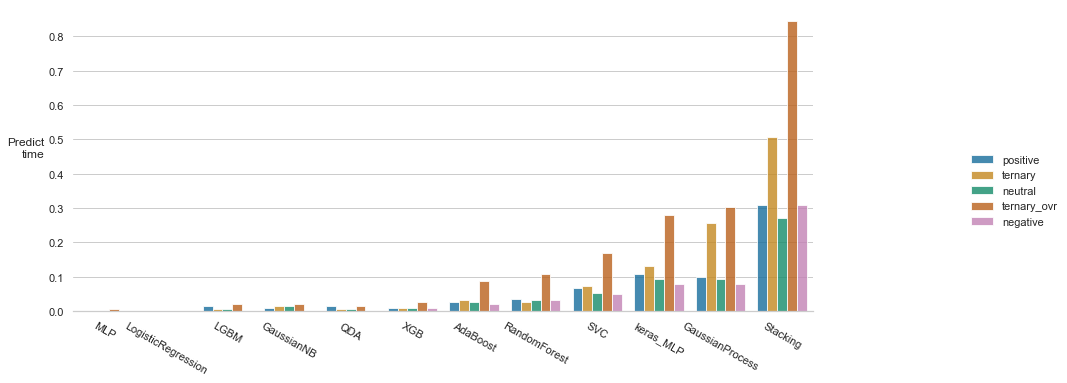

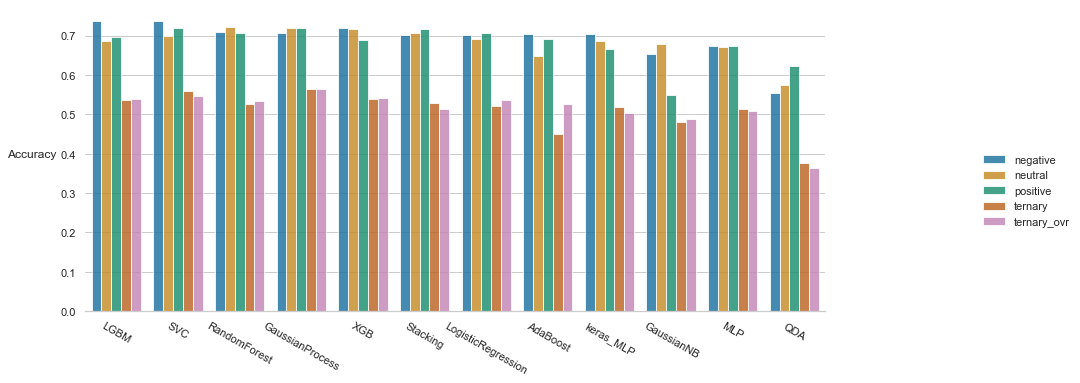

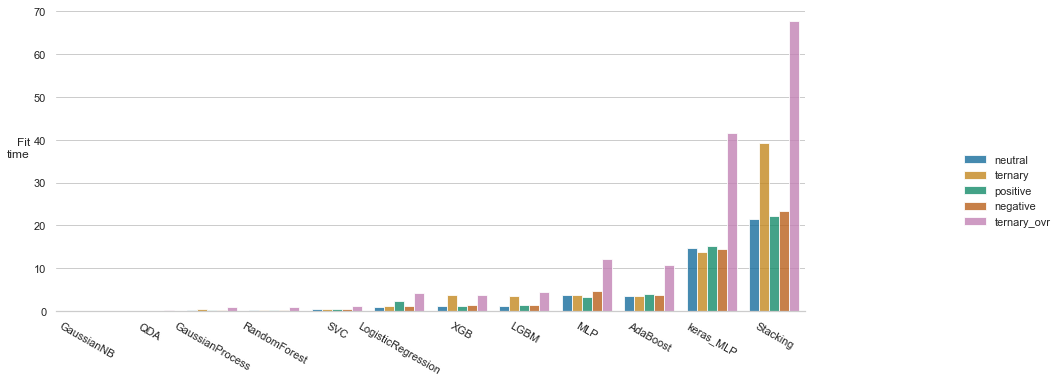

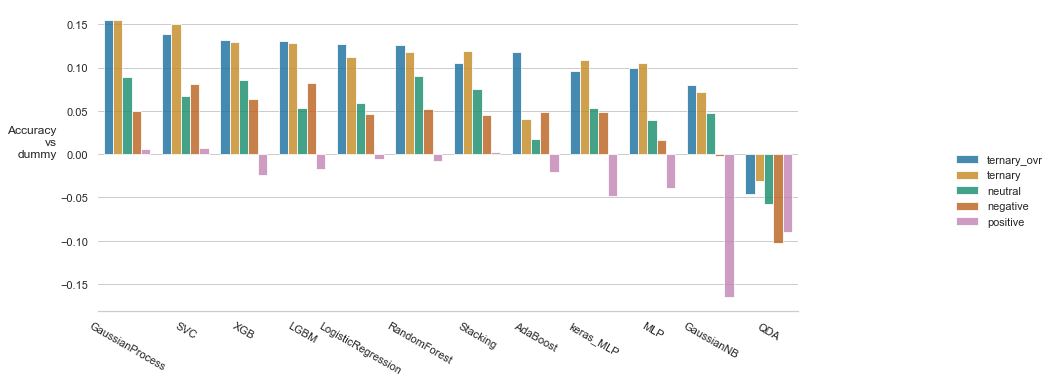

time: 4.44 s


In [38]:
for metric in metrics:
    plot_metric(metric)

We will visualize feature importances of the meta-estimator too.

Text(35.67732291666667, 0.5, 'importance')

Text(0.5, 0.98, 'importance of classifiers in stack')

Text(0.5, 20.80000000000001, '')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MLP'),
  Text(1, 0, 'LogisticRegression'),
  Text(2, 0, 'QDA'),
  Text(3, 0, 'GaussianNB'),
  Text(4, 0, 'GaussianProcess'),
  Text(5, 0, 'LGBM'),
  Text(6, 0, 'XGB'),
  Text(7, 0, 'AdaBoost'),
  Text(8, 0, 'SVC'),
  Text(9, 0, 'RandomForest')])

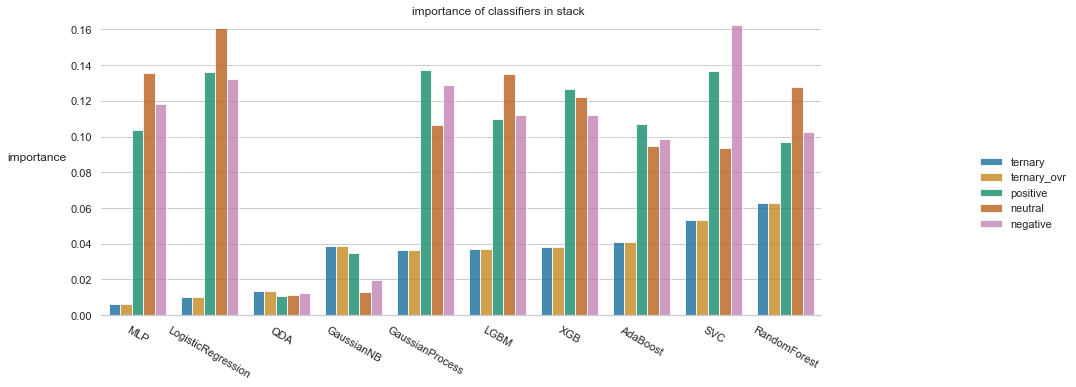

time: 782 ms


In [39]:
g = sns.catplot(
    data=df_importance.sort_values(by="importance"),
    kind="bar",
    x="model",
    y="importance",
    hue="case",
    palette="colorblind",
    alpha=0.8,
)
g.fig.set_figwidth(16)
g.despine(**dict.fromkeys(("left", "top", "right"), True))
g.legend.set_title("")
plt.ylabel("importance", rotation=0, ha="right")
plt.suptitle("importance of classifiers in stack")
plt.xlabel("")
plt.xticks(rotation=-30)
plt.show()

## Discussion

In [40]:
best = {
    case: {metric: {"model": "", "score": 0} for metric in metrics}
    for case in all_cases
}
for case in best.keys():
    for metric in metrics:
        base = results_df.loc[results_df.case == case][["model_name", metric]]
        base_metric = base[metric]
        best_case_metric = best[case][metric]
        best_case_metric["score"] = base_metric[
            (
                score_idx := base_metric.idxmin()
                if "time" in metric
                else base_metric.idxmax()
            )
        ]
        best_case_metric["model"] = base.model_name[score_idx]

time: 47 ms


In [41]:
for case in best:
    for metric in best[case]:
        best_case = best[case]
        print(
            f"The best-performing model in terms of {metric_names[metric].lower()} was {best_case[metric]['model']} for {case} classification with a score of {best_case[metric]['score']:.3f}{' s' if 'time' in metric else ''}."
        )

The best-performing model in terms of predict time was LogisticRegression for positive classification with a score of 0.000 s.
The best-performing model in terms of accuracy was SVC for positive classification with a score of 0.720.
The best-performing model in terms of fit time was GaussianNB for positive classification with a score of 0.010 s.
The best-performing model in terms of accuracy vs dummy was SVC for positive classification with a score of 0.007.
The best-performing model in terms of predict time was LogisticRegression for ternary_ovr classification with a score of 0.000 s.
The best-performing model in terms of accuracy was GaussianProcessClassifier for ternary_ovr classification with a score of 0.563.
The best-performing model in terms of fit time was GaussianNB for ternary_ovr classification with a score of 0.031 s.
The best-performing model in terms of accuracy vs dummy was GaussianProcessClassifier for ternary_ovr classification with a score of 0.155.
The best-performin

Quadratic Discriminant Analysis performed poorly, probably due to high multicollinearity in the FRILL vector. 

GaussianNB was fast but not a contender for highest accuracy.

GaussianProcessClassifier was the best-performing classifier in both ternary classification tasks.

Individual subestimators within the Stacking Classifier outperformed the stack. Selecting the worst-performing subestimators for removal from the stack will likely boost its performance. Recursive feature elimination is a possible strategy to achieve this.

The neural network models could potentially rank higher with more tuning. For all but the worst algorithms, hyperparameter tuning is expected to improve results as well.

Of the five classification scenarios, accuracy is consistently the worst for the positive/non-positive binary classification case. Class imbalance is the most severe in this scenario. This effect may even out as more data is introduced downstream, but measures to address imbalance directly may be appropriate.

I actually had trouble interpreting the multinomial coefficients of the `LogisticRegression` meta-estimator, so I [asked about it on Stack Overflow](#https://stackoverflow.com/questions/69640194/how-to-interpret-logisticregression-coefficients-ternary-classification-with-sk). In the meantime, I used a random forest instead. The plot suggests that certain classifiers may be especially informative in binary classification scenarios.

Another approach may be to perform ternary classification by first predicting neutral/non-neutral and only disambiguating the non-neutral observations with positive/negative classification. An underlying assumption is that neutrally valenced utterances cannot be simultaneously positively or negatively valenced. The disambiguating predictions may be performed in 1) a binary fashion (positive vs. negative) or 2) a one-vs-rest fashion (% positive vs. % negative). The former does not allow for mixed states (simulatneous positive and negative valence) but has the advantage of relying on two underpinnning models rather than three. Although slower than the former, the latter may still afford some time savings at inference compared to the direct ternary case while preserving the interpretation of mixed states with predicted probabilities that may exceed 1 in sum. Nevertheless, the former may approximate the mixed-states interpretation via softmax predictions, which would yield two probabilities that sum to 1. Since the simple classification accuracy of the neutral binary case exceeds that of the ternary cases for all classifiers, this may be a viable approach.

It is important to try the same methods on a more representative sample of the whole dataset; there is no guarantee of similar performance between samples of differing duration.

### Considerations for refactoring

I found out about `sklearn.multiclass.OneVsRestClassifier` right after I finished building the test harness. It is likely that `sklearn` implements some optimizations that I did not. In refactoring, I would consider using the `sklearn` classifier rather than my own implementation.

Similarly, the test harness could be revised such that the `StackingClassifier` is trained first. A fitted `StackingClassifier` retains access to its fitted subestimators. Consequently, the performance of all subestimators may be recorded in aggregate per fold. Although the fit and predict times of subestimators would not be recorded, this may be less relevant when upper bounds on fit/predict times have already been estimated.

In addition, implementing a factory method design pattern may make the test harness more compact in refactoring.

Furthermore, the custom train-test split logic could be repackaged into an iterable yielding splits compatible with the `cv` parameter of many `sklearn` methods.

[^top](#Contents)